# Week two Refining your data 

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ipaddress
import json

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = (10,5)



## Replace 'your_file.csv' with the path to your CSV file

In [2]:
# Cell 2 - load csv
csv_file = 'cowrie_2024-02-07.csv'   # <-- change if your file is named differently
df = pd.read_csv(csv_file)

print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())
# quick peek for screenshot
display(df.head(8))



Loaded rows: 2472
Columns: ['timestamp', 'eventid', 'src_ip', 'username', 'password', 'sensor', 'message']


timestamp                 eventid         src_ip  \
0  2024-02-07T00:48:24.402171Z  cowrie.session.connect  75.119.144.68   
1  2024-02-07T00:48:27.822160Z   cowrie.session.closed  75.119.144.68   
2  2024-02-07T00:48:27.916707Z  cowrie.session.connect  75.119.144.68   
3  2024-02-07T00:48:30.534384Z   cowrie.client.version  75.119.144.68   
4  2024-02-07T00:48:30.535620Z       cowrie.client.kex  75.119.144.68   
5  2024-02-07T00:48:56.141345Z    cowrie.login.success  75.119.144.68   
6  2024-02-07T00:49:28.574598Z   cowrie.session.params  75.119.144.68   
7  2024-02-07T00:49:28.575549Z    cowrie.command.input  75.119.144.68   

  username          password        sensor  \
0      NaN               NaN  d647d7cf7742   
1      NaN               NaN  d647d7cf7742   
2      NaN               NaN  d647d7cf7742   
3      NaN               NaN  d647d7cf7742   
4      NaN               NaN  d647d7cf7742   
5     root  ------fuck------  d647d7cf7742   
6      NaN               NaN  d647d7cf7742   
7      NaN               NaN  d647d7cf7742   

                                             message  
0  New connection: 75.119.144.68:56824 (172.17.0....  
1                    Connection lost after 3 seconds  
2  New connection: 75.119.144.68:56828 (172.17.0....  
3                     Remote SSH version: SSH-2.0-Go  
4  SSH client hassh fingerprint: 98f63c4d9c87edbd...  
5    login attempt [root/------fuck------] succeeded  
6                                                 []  
7                                   CMD: uname -s -m

## Identify categorical columns (object type)

In [3]:
# Cell 3 - timestamp normalization & initial cleaning
# Many Cowrie timestamps are ISO8601 like: 2024-02-07T00:48:24.402171Z
def parse_iso_ts(s):
    try:
        return pd.to_datetime(s, utc=True)
    except Exception:
        return pd.NaT

# Ensure timestamp column exists
if 'timestamp' not in df.columns:
    raise RuntimeError("Expected 'timestamp' column in CSV")

df['timestamp_parsed'] = df['timestamp'].apply(parse_iso_ts)
print("Parsed timestamps: non-null count =", df['timestamp_parsed'].notna().sum())

# Drop rows with missing timestamps since time context is required for our temporal features
before = len(df)
df = df.dropna(subset=['timestamp_parsed']).reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} rows without valid timestamp (kept {after}).")

# lowercase eventid for consistency
if 'eventid' in df.columns:
    df['eventid'] = df['eventid'].astype(str).str.strip().str.lower()

# ensure src_ip exists
if 'src_ip' not in df.columns:
    # try to extract IP from message if not present
    ip_re = re.compile(r'((?:\d{1,3}\.){3}\d{1,3})')
    df['src_ip'] = df['message'].astype(str).apply(lambda m: (ip_re.search(m).group(1) if ip_re.search(m) else np.nan))

# validate IPs and set invalid to NaN
def valid_ip(s):
    try:
        if pd.isna(s): 
            return False
        ipaddress.ip_address(str(s))
        return True
    except Exception:
        return False

df['src_ip'] = df['src_ip'].where(df['src_ip'].apply(valid_ip), np.nan)

# quick counts
print("Unique src_ip count:", df['src_ip'].nunique(dropna=True))
print("Unique eventid examples:", df['eventid'].unique()[:12])


Parsed timestamps: non-null count = 2472
Dropped 0 rows without valid timestamp (kept 2472).
Unique src_ip count: 24
Unique eventid examples: ['cowrie.session.connect' 'cowrie.session.closed' 'cowrie.client.version'
 'cowrie.client.kex' 'cowrie.login.success' 'cowrie.session.params'
 'cowrie.command.input' 'cowrie.log.closed' 'cowrie.direct-tcpip.request'
 'cowrie.direct-tcpip.data' 'cowrie.login.failed']


##  Create a dictionary to hold DataFrames for each category

In [4]:
# Cell 4 - parse message for username/password/session/ssh-version
# Patterns commonly in the Cowrie message field:
# - "login attempt [user/pass] failed" or "login attempt [user/pass] succeeded"
# - "New connection: <ip>:<port> (..."
# - "SSH client hassh fingerprint: <fingerprint>"
# - "Remote SSH version: SSH-2.0-OpenSSH_7.4" or sometimes binary blobs

# regex patterns
login_re = re.compile(r'login attempt \[(?P<user>[^/\]]+?)/(?P<pass>[^\]]+?)\] (?P<result>failed|succeeded)', re.IGNORECASE)
newconn_re = re.compile(r'new connection: (?P<src>[\d\.]+):(?P<src_port>\d+)', re.IGNORECASE)
sshver_re = re.compile(r'remote ssh version:\s*(?P<sshver>[^\]]+)', re.IGNORECASE)
session_re = re.compile(r'\[session:\s*(?P<session>[0-9a-fA-F]+)\]', re.IGNORECASE)

def extract_fields(row):
    m_login = login_re.search(str(row['message']))
    m_conn = newconn_re.search(str(row['message']))
    m_ssh = sshver_re.search(str(row['message']))
    m_sess = session_re.search(str(row['message']))
    return pd.Series({
        'parsed_user': m_login.group('user') if m_login else np.nan,
        'parsed_password': m_login.group('pass') if m_login else np.nan,
        'login_result': (m_login.group('result').lower() if m_login else np.nan),
        'msg_newconn_ip': m_conn.group('src') if m_conn else np.nan,
        'msg_newconn_port': (int(m_conn.group('src_port')) if m_conn else np.nan),
        'ssh_version': m_ssh.group('sshver').strip() if m_ssh else np.nan,
        'session_id': m_sess.group('session') if m_sess else np.nan
    })

parsed_cols = df.apply(extract_fields, axis=1)
df = pd.concat([df, parsed_cols], axis=1)

# Fill src_ip from message new connection IP when src_ip missing
df['src_ip'] = df['src_ip'].fillna(df['msg_newconn_ip'])

# Standardize login_result values
df['login_result'] = df['login_result'].where(df['login_result'].notna(), np.nan)

# Show cleaned head for screenshot (this covers "screenshot of code execution")
print("Cleaned and parsed DataFrame (head):")
display(df[['timestamp_parsed','eventid','src_ip','parsed_user','parsed_password','login_result','ssh_version','session_id','message']].head(12))


Cleaned and parsed DataFrame (head):


timestamp_parsed                 eventid         src_ip  \
0  2024-02-07 00:48:24.402171+00:00  cowrie.session.connect  75.119.144.68   
1  2024-02-07 00:48:27.822160+00:00   cowrie.session.closed  75.119.144.68   
2  2024-02-07 00:48:27.916707+00:00  cowrie.session.connect  75.119.144.68   
3  2024-02-07 00:48:30.534384+00:00   cowrie.client.version  75.119.144.68   
4  2024-02-07 00:48:30.535620+00:00       cowrie.client.kex  75.119.144.68   
5  2024-02-07 00:48:56.141345+00:00    cowrie.login.success  75.119.144.68   
6  2024-02-07 00:49:28.574598+00:00   cowrie.session.params  75.119.144.68   
7  2024-02-07 00:49:28.575549+00:00    cowrie.command.input  75.119.144.68   
8  2024-02-07 00:49:33.318910+00:00       cowrie.log.closed  75.119.144.68   
9  2024-02-07 00:49:33.320167+00:00   cowrie.session.closed  75.119.144.68   
10 2024-02-07 01:15:28.735830+00:00  cowrie.session.connect   198.74.56.46   
11 2024-02-07 01:15:29.066649+00:00   cowrie.session.closed   198.74.56.46   

   parsed_user   parsed_password login_result ssh_version    session_id  \
0          NaN               NaN          NaN         NaN  5ee36a44ad01   
1          NaN               NaN          NaN         NaN           NaN   
2          NaN               NaN          NaN         NaN  cec4878611ec   
3          NaN               NaN          NaN  SSH-2.0-Go           NaN   
4          NaN               NaN          NaN         NaN           NaN   
5         root  ------fuck------    succeeded         NaN           NaN   
6          NaN               NaN          NaN         NaN           NaN   
7          NaN               NaN          NaN         NaN           NaN   
8          NaN               NaN          NaN         NaN           NaN   
9          NaN               NaN          NaN         NaN           NaN   
10         NaN               NaN          NaN         NaN  f5a8a37162ff   
11         NaN               NaN          NaN         NaN           NaN   

                                              message  
0   New connection: 75.119.144.68:56824 (172.17.0....  
1                     Connection lost after 3 seconds  
2   New connection: 75.119.144.68:56828 (172.17.0....  
3                      Remote SSH version: SSH-2.0-Go  
4   SSH client hassh fingerprint: 98f63c4d9c87edbd...  
5     login attempt [root/------fuck------] succeeded  
6                                                  []  
7                                    CMD: uname -s -m  
8   Closing TTY Log: var/lib/cowrie/tty/6fa4c8ac58...  
9                    Connection lost after 65 seconds  
10  New connection: 198.74.56.46:57421 (172.17.0.2...  
11                    Connection lost after 0 seconds

In [5]:
# Cell 5 - create feature indicators & print selection (these are the three features we'll submit)
# Feature A: Frequency of NEW CONNECTIONS per src_ip (count of cowrie.session.connect events) -> indicates scanning/volume
# Feature B: Login success/failure counts per src_ip and per username -> indicates brute-force and possible compromise
# Feature C: Distribution of SSH client versions (ssh_version) per src_ip -> fingerprint/version anomalies may indicate unusual clients or scanning tools

# create boolean columns
df['is_new_connection'] = df['eventid'].str.contains('session.connect', na=False)
df['is_login_failed'] = df['eventid'].str.contains('login.failed', na=False)
df['is_login_success'] = df['eventid'].str.contains('login.success', na=False)

print("Selected Parsing Items (to include in report):")
print("1) new_connection_count_per_src_ip  (counts of 'cowrie.session.connect')  -> detects scan/volume anomalies")
print("2) login_failed_count / login_success_count  (per src_ip and per username) -> detects brute-force and credential compromise indicators")
print("3) ssh_version_distribution  (ssh versions per src_ip, and rare/unknown versions flagged) -> detects unusual clients/scanners\n")


Selected Parsing Items (to include in report):
1) new_connection_count_per_src_ip  (counts of 'cowrie.session.connect')  -> detects scan/volume anomalies
2) login_failed_count / login_success_count  (per src_ip and per username) -> detects brute-force and credential compromise indicators
3) ssh_version_distribution  (ssh versions per src_ip, and rare/unknown versions flagged) -> detects unusual clients/scanners



In [6]:
# Cell 6 - aggregations for features

# ensure timestamp is timezone-aware/datetime
df['ts_utc'] = pd.to_datetime(df['timestamp_parsed'], utc=True)

# per-IP aggregation
ip_agg = df.groupby('src_ip').agg(
    total_events = ('eventid','count'),
    newconn_count = ('is_new_connection','sum'),
    login_failed_count = ('is_login_failed','sum'),
    login_success_count = ('is_login_success','sum'),
    unique_users = ('parsed_user', lambda s: s.dropna().nunique())
).reset_index()

# derived rates
ip_agg['failure_rate'] = ip_agg['login_failed_count'] / ip_agg['total_events']
ip_agg['success_rate'] = ip_agg['login_success_count'] / ip_agg['total_events']

# ssh version distribution per ip (we'll compute top ssh version and # distinct versions)
ssh_by_ip = df.dropna(subset=['ssh_version']).groupby('src_ip')['ssh_version'].agg(lambda s: s.value_counts().index[0] if len(s)>0 else np.nan).rename('top_ssh_version').reset_index()
ssh_count_by_ip = df.dropna(subset=['ssh_version']).groupby('src_ip')['ssh_version'].nunique().rename('distinct_ssh_versions').reset_index()

# merge ssh aggregates into ip_agg
ip_agg = ip_agg.merge(ssh_by_ip, on='src_ip', how='left').merge(ssh_count_by_ip, on='src_ip', how='left')

# sort by newconn_count or login_failed_count for risk
ip_agg = ip_agg.sort_values(by=['login_failed_count','newconn_count'], ascending=False).reset_index(drop=True)

print("Per-IP feature table (first 12 rows) — use this for your screenshot / feature CSV:")
display(ip_agg.head(12))

# per-user aggregation (useful for report and appendices)
user_agg = df.groupby('parsed_user').agg(
    total_attempts=('eventid','count'),
    failed=('is_login_failed','sum'),
    success=('is_login_success','sum'),
).reset_index().sort_values(by='failed', ascending=False)

print("\nPer-username sample (top 12 by failed attempts):")
display(user_agg.head(12))


Per-IP feature table (first 12 rows) — use this for your screenshot / feature CSV:


src_ip  total_events  newconn_count  login_failed_count  \
0    138.197.64.59          2114            400                 360   
1    85.209.11.227            68             11                   1   
2    193.201.9.104           175             25                   0   
3   172.105.128.11            25              7                   0   
4   185.233.19.141            10              4                   0   
5    45.79.168.172             8              4                   0   
6    152.32.183.27            10              3                   0   
7   167.248.133.38             6              2                   0   
8    167.94.145.53             6              2                   0   
9   192.155.88.231             4              2                   0   
10    198.74.56.46             4              2                   0   
11   43.133.134.74             7              2                   0   

    login_success_count  unique_users  failure_rate  success_rate  \
0                    39           172      0.170293      0.018448   
1                     9             2      0.014706      0.132353   
2                    25             1      0.000000      0.142857   
3                     0             0      0.000000      0.000000   
4                     0             0      0.000000      0.000000   
5                     0             0      0.000000      0.000000   
6                     0             0      0.000000      0.000000   
7                     0             0      0.000000      0.000000   
8                     0             0      0.000000      0.000000   
9                     0             0      0.000000      0.000000   
10                    0             0      0.000000      0.000000   
11                    0             0      0.000000      0.000000   

        top_ssh_version  distinct_ssh_versions  
0            SSH-2.0-Go                    1.0  
1            SSH-2.0-Go                    1.0  
2            SSH-2.0-Go                    1.0  
3            SSH-2.0-Go                    2.0  
4            SSH-2.0-Go                    1.0  
5                   NaN                    NaN  
6   SSH-2.0-OpenSSH_7.4                    1.0  
7            SSH-2.0-Go                    1.0  
8            SSH-2.0-Go                    1.0  
9                   NaN                    NaN  
10                  NaN                    NaN  
11                                      2.0


Per-username sample (top 12 by failed attempts):


parsed_user  total_attempts  failed  success
105      oracle              16      16        0
8         admin              10      10        0
14      airflow              10      10        0
160      ubuntu              10      10        0
161        user               9       9        0
120    postgres               8       8        0
128       regix               8       8        0
78       ingres               8       8        0
60     ftpadmin               6       6        0
68         grid               6       6        0
84    loginuser               5       5        0
85        louis               5       5        0

In [7]:
# Cell 7 - normalization and exports
feature_cols = ['total_events','newconn_count','login_failed_count','login_success_count','unique_users','failure_rate','success_rate','distinct_ssh_versions']
for c in feature_cols:
    if c not in ip_agg.columns:
        ip_agg[c] = 0

# simple min-max scaling
scaled = ip_agg.copy()
for col in ['total_events','newconn_count','login_failed_count','login_success_count','unique_users','distinct_ssh_versions','failure_rate','success_rate']:
    mn = scaled[col].min()
    mx = scaled[col].max()
    if pd.isna(mn) or pd.isna(mx) or mx==mn:
        scaled[col + '_scaled'] = 0.0
    else:
        scaled[col + '_scaled'] = (scaled[col] - mn) / (mx - mn)

# final features for model (scaled)
final_features = scaled[['src_ip'] + [col for col in scaled.columns if col.endswith('_scaled')]].copy()
final_features = final_features.rename(columns={'src_ip':'ip'})

# Save outputs
ip_agg.to_csv('ids_week2_ip_aggregates.csv', index=False)
final_features.to_csv('ids_week2_features_scaled_by_ip.csv', index=False)
df.to_csv('ids_week2_parsed_cleaned.csv', index=False)

print("Exported: ids_week2_ip_aggregates.csv, ids_week2_features_scaled_by_ip.csv, ids_week2_parsed_cleaned.csv")
print("Feature table saved (first 12 rows):")
display(final_features.head(12))


Exported: ids_week2_ip_aggregates.csv, ids_week2_features_scaled_by_ip.csv, ids_week2_parsed_cleaned.csv
Feature table saved (first 12 rows):


ip  total_events_scaled  newconn_count_scaled  \
0    138.197.64.59             1.000000              1.000000   
1    85.209.11.227             0.031250              0.025063   
2    193.201.9.104             0.081913              0.060150   
3   172.105.128.11             0.010890              0.015038   
4   185.233.19.141             0.003788              0.007519   
5    45.79.168.172             0.002841              0.007519   
6    152.32.183.27             0.003788              0.005013   
7   167.248.133.38             0.001894              0.002506   
8    167.94.145.53             0.001894              0.002506   
9   192.155.88.231             0.000947              0.002506   
10    198.74.56.46             0.000947              0.002506   
11   43.133.134.74             0.002367              0.002506   

    login_failed_count_scaled  login_success_count_scaled  \
0                    1.000000                    1.000000   
1                    0.002778                    0.230769   
2                    0.000000                    0.641026   
3                    0.000000                    0.000000   
4                    0.000000                    0.000000   
5                    0.000000                    0.000000   
6                    0.000000                    0.000000   
7                    0.000000                    0.000000   
8                    0.000000                    0.000000   
9                    0.000000                    0.000000   
10                   0.000000                    0.000000   
11                   0.000000                    0.000000   

    unique_users_scaled  distinct_ssh_versions_scaled  failure_rate_scaled  \
0              1.000000                           0.0             1.000000   
1              0.011628                           0.0             0.086356   
2              0.005814                           0.0             0.000000   
3              0.000000                           1.0             0.000000   
4              0.000000                           0.0             0.000000   
5              0.000000                           NaN             0.000000   
6              0.000000                           0.0             0.000000   
7              0.000000                           0.0             0.000000   
8              0.000000                           0.0             0.000000   
9              0.000000                           NaN             0.000000   
10             0.000000                           NaN             0.000000   
11             0.000000                           1.0             0.000000   

    success_rate_scaled  
0              0.129139  
1              0.926471  
2              1.000000  
3              0.000000  
4              0.000000  
5              0.000000  
6              0.000000  
7              0.000000  
8              0.000000  
9              0.000000  
10             0.000000  
11             0.000000

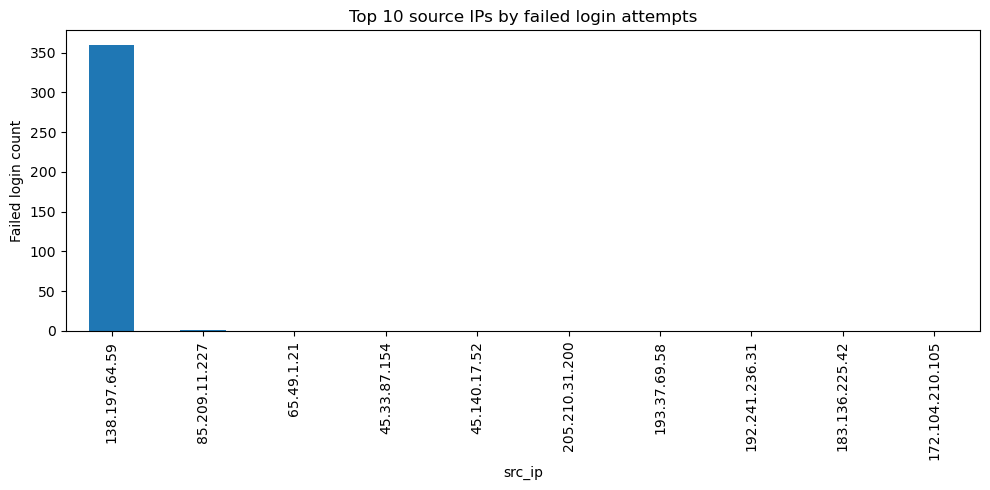

/tmp/ipykernel_4002/4086966825.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conn_per_min = df.resample('1T', on='ts_utc').size().rename('connections_per_minute').reset_index()


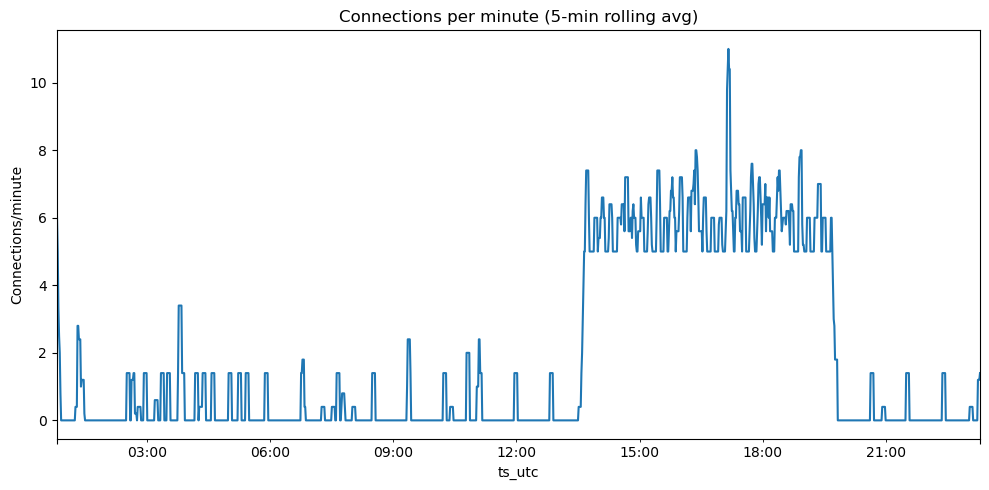

/tmp/ipykernel_4002/4086966825.py:24: UserWarning: Glyph 22 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4002/4086966825.py:24: UserWarning: Glyph 3 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4002/4086966825.py:24: UserWarning: Glyph 1 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/student/anaconda3/envs/MSCS_Project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/student/anaconda3/envs/MSCS_Project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/student/anaconda3/envs/MSCS_Project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 1 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


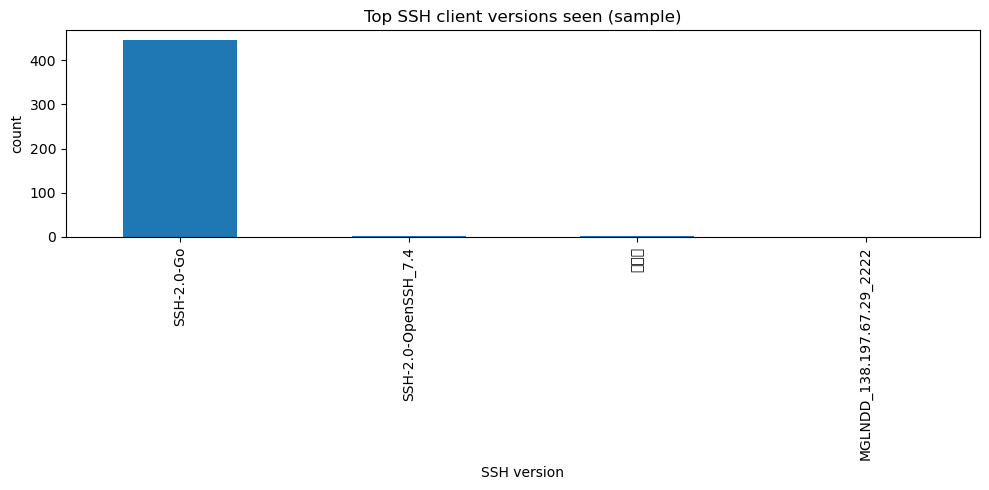

In [8]:
# Cell 8 - plots (use these for screenshot)
# 1. Top 10 IPs by failed login attempts
top_failed = ip_agg.sort_values('login_failed_count', ascending=False).head(10).set_index('src_ip')
ax = top_failed['login_failed_count'].plot(kind='bar', title='Top 10 source IPs by failed login attempts')
ax.set_xlabel('src_ip')
ax.set_ylabel('Failed login count')
plt.tight_layout()
plt.show()

# 2. Connection volume over time (global)
df.set_index('ts_utc', inplace=False)
conn_per_min = df.resample('1T', on='ts_utc').size().rename('connections_per_minute').reset_index()
ax = conn_per_min.set_index('ts_utc')['connections_per_minute'].rolling(5, min_periods=1).mean().plot(title='Connections per minute (5-min rolling avg)')
ax.set_ylabel('Connections/minute')
plt.tight_layout()
plt.show()

# 3. SSH version counts (top 12)
ssh_counts = df['ssh_version'].value_counts().head(12)
if len(ssh_counts) > 0:
    ssh_counts.plot(kind='bar', title='Top SSH client versions seen (sample)')
    plt.xlabel('SSH version')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()
else:
    print("No SSH version strings found in this dataset to plot.")


In [9]:
# Cell 9 - cleaning summary (print and save as JSON to include in Methods section)
cleaning_summary = {
    'raw_rows_loaded': len(pd.read_csv(csv_file)),
    'rows_after_timestamp_drop': len(df),
    'unique_src_ips': int(df['src_ip'].nunique(dropna=True)),
    'rows_with_parsed_user': int(df['parsed_user'].notna().sum()),
    'rows_with_ssh_version': int(df['ssh_version'].notna().sum())
}
print("CLEANING SUMMARY (copy into Methods section):")
print(json.dumps(cleaning_summary, indent=2))

# Save to file for the appendix
with open('cleaning_summary_week2.json','w') as fh:
    json.dump(cleaning_summary, fh, indent=2)
print("Saved cleaning_summary_week2.json")


CLEANING SUMMARY (copy into Methods section):
{
  "raw_rows_loaded": 2472,
  "rows_after_timestamp_drop": 2472,
  "unique_src_ips": 24,
  "rows_with_parsed_user": 435,
  "rows_with_ssh_version": 450
}
Saved cleaning_summary_week2.json
